In [5]:
from lagrangian import LagrangianSolver
from dataclasses import dataclass

import torch
import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from typing import Tuple

In [3]:
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

plt.rc('font', family='serif', serif="cmr10", size=18)
plt.rc('mathtext', fontset='cm', rm='serif')
plt.rc('axes', unicode_minus=False)

plt.rcParams['axes.formatter.use_mathtext'] = True

# Minimal Example: Dampening and Constraints

In [ ]:
@dataclass
class ConstrainedDampedPendulum(LagrangianSolver):
    m: float
    R: float
    c: float
    g: float = 9.81

    def T(self, u: torch.Tensor) -> torch.Tensor:
        t, x,y, xdot,ydot = u
        return self.m*(xdot.square() + ydot.square())/2

    def V(self, u: torch.Tensor) -> torch.Tensor:
        t, x,y, xdot,xydot = u
        return self.m*self.g*(y + self.R)
    
    def Q(self, u: torch.Tensor) -> torch.Tensor:
        # damping term
        t, x,y, xdot, ydot = u
        r2 = x.square() + y.square()
        theta_dot = x/r2*ydot - (y/r2)*xdot
        return self.c * theta_dot.square() / 2

    def constraints(self, u: torch.Tensor) -> Tuple[torch.Tensor]:
        t, x,y, xdot,ydot = u
        # must have dim >= 1 for vector operations
        return (x.square() + y.square() - self.R**2).unsqueeze(0)

In [26]:
solver = ConstrainedDampedPendulum(m=1., R=1., c=1.)

theta0 = torch.tensor(0.1)

u0 = torch.tensor([
    solver.R*theta0.sin(), -solver.R*theta0.cos(), # [x,y]
    0., 0. # [xdot, ydot]
], dtype=torch.float64)

T = 10
N = 250
t = torch.linspace(0,T,N)

soln = solver.solve(u0, t)
(u, E) = (soln['u'], soln['E'])

100%|██████████| 249/249 [00:01<00:00, 191.64it/s]


In [28]:
omega = math.sqrt(solver.g/solver.R)
gamma = solver.c /(2*solver.m*solver.R**2)

omega_d = math.sqrt(omega**2 - gamma**2)

theta_ex = lambda t : (
    theta0 * (-gamma*t).exp() * (
        (omega_d*t).cos() + gamma/omega_d*(omega_d*t).sin()
    ) 
)

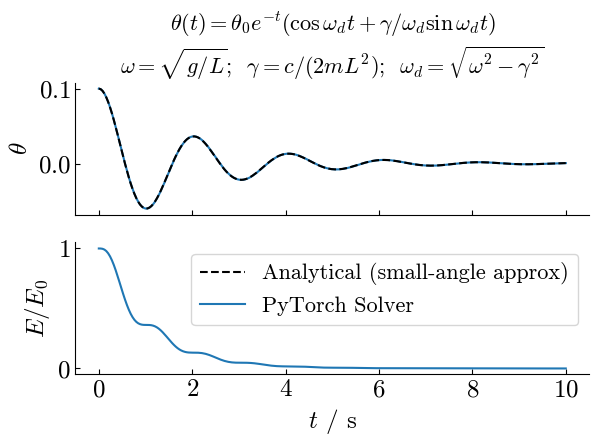

In [30]:
theta = torch.arctan2(u[:,0], -u[:,1])

fig, ax = plt.subplots(2, 1, sharex=True)

ax[0].plot(t, theta)
ax[0].plot(t, theta_ex(t), 'k--', label=r'')
ax[1].plot(0,1 , 'k--', label='Analytical (small-angle approx)')
ax[1].plot(t, E/E[0], label='PyTorch Solver')
ax[0].set_ylabel(r'$\theta$')
ax[1].set_ylabel(r'$E/E_0$')
ax[1].set_xlabel('$t$ / s')
ax[1].legend(fontsize=16)

ax[0].set_title(
    r'$\theta(t) = \theta_0 e^{-t}(\cos \omega_d t + \gamma/\omega_d \sin\omega_d t)$' +'\n' + 
    r'$\omega = \sqrt{g/L}$;  $\gamma = c/(2mL^2)$;  $\omega_d = \sqrt{\omega^2 - \gamma^2}$', 
    size=16
)

fig.tight_layout()